In [1]:
import pandas as pd
import numpy as np
import numpy.linalg
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
prob_df = pd.read_csv('/content/drive/My Drive/SIADS 699: Capstone/Clean Data/prob_data_complete.csv')

In [20]:
'''
Data Preparation:
- ensure timestamp column(s) are in pandas datetime format
- sort by username and timestamp
- calculate the time between submissions/activities using problem timestamp
- using time difference, define a session by groups of submissions each within at most 30 minutes of each other **vary the time and see how that changes
- filter sessions that are shorter than 15 minutes **vary the time and see how that changes
'''

prob_df['timestamp'] = pd.to_datetime(prob_df['timestamp'])
prob_df = prob_df.sort_values(by=['username', 'timestamp'])
prob_df['time_diff'] = prob_df.groupby('username')['timestamp'].diff()

session_threshold = pd.Timedelta(minutes=30)
prob_df['new_session'] = ((prob_df['time_diff'] > session_threshold) | (prob_df['time_diff'].isnull()))
prob_df['session_id'] = prob_df.groupby('username')['new_session'].cumsum()

session_summary = prob_df.groupby(['username', 'session_id'])['timestamp'].agg(['min', 'max'])
session_summary['session_length'] = (session_summary['max'] - session_summary['min']).dt.total_seconds()/60
valid_threshold = 15
valid_sessions = session_summary[session_summary['session_length'] >= valid_threshold].index
session_df = prob_df.set_index(['username', 'session_id']).loc[valid_sessions].reset_index()

In [21]:
'''
Feature Engineering:
- drop date/time columns where timestamps are present, redundant
- drop probs_before_mastery
- drop time_diff and new_session
- create new column session_duration
- create new session aggregate features (average correct, number of problems, number of practice, number of quizzes, number of mastered problems)
- create new session feature listing unique problem types
- create new session feature listing session path (practice/quiz)
'''

session_df = session_df.drop(['date', 'time', 'mastery_date', 'mastery_time', 'probs_before_mastery', 'time_to_mastery', 'mastery_timestamp', 'time_diff', 'new_session'], axis=1)

def extract_session_features(session):

  session = session.sort_values(by='timestamp')
  duration = (session['timestamp'].max() - session['timestamp'].min()).total_seconds()/60

  num_probs = len(session)
  num_practice_probs = session['practice'].sum()
  num_quiz_probs = session['quiz_time'].notnull().sum()
  num_quizzes = session['quiz_time'].dropna().nunique()
  num_mastered_probs = session['mastery'].sum()
  num_unique_probs = session['prob_name'].nunique()

  avg_correct = session['correct'].mean()
  avg_practice_correct = session.loc[session['practice'] == 1, 'correct'].mean()
  avg_quiz_correct = session.loc[session['practice'] == 0, 'correct'].mean()
  avg_mastered_correct = session.loc[session['mastery'] == 1, 'correct'].mean()
  avg_not_mastered_correct = session.loc[session['mastery'] == 0, 'correct'].mean()

  unique_probs = list(session['prob_name'].unique())
  session_path = ''.join(session['practice'].map(lambda x: 'p' if x == 1 else 'q').tolist())

  return pd.Series({
      'session_duration': duration,
      'num_probs': num_probs,
      'num_unique_probs': num_unique_probs,
      'num_practice_probs': num_practice_probs,
      'num_quiz_probs': num_quiz_probs,
      'num_quizzes': num_quizzes,
      'num_mastered_probs': num_mastered_probs,
      'avg_correct': avg_correct,
      'avg_practice_correct': avg_practice_correct,
      'avg_quiz_correct': avg_quiz_correct,
      'avg_mastered_correct': avg_mastered_correct,
      'avg_not_mastered_correct': avg_not_mastered_correct,
      'unique_probs': unique_probs,
      'session_path': session_path
    })

session_df = session_df.groupby(['username', 'session_id']).apply(extract_session_features).reset_index()

<ipython-input-21-53585643cd9f>:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  session_df = session_df.groupby(['username', 'session_id']).apply(extract_session_features).reset_index()


In [5]:
session_df.head(3)

,username,session_id,session_duration,num_probs,num_unique_probs,num_practice_probs,num_quiz_probs,num_quizzes,num_mastered_probs,avg_correct,avg_practice_correct,avg_quiz_correct,avg_mastered_correct,avg_not_mastered_correct,unique_probs,session_path
0,AyaA2,1,48.433333,59,5,28,31,8,0,0.847458,0.821429,0.870968,NaN,0.847458,"[MD2, AS2, COM2, MD3, LG3]",qqqqqqqqqqqqqqqqqqqqqqpppppppppppppqqqqqqqqqpp...
1,AyaA2,2,49.083333,173,4,119,54,18,15,0.965318,0.974790,0.944444,0.933333,0.968354,"[AS2, MD2, COM2, COM3]",qqqqqpqqqqqqqqqqqqqqqqqqqqpppppppqqqqqqqqqqqqq...
2,AyaA2,3,29.683333,228,2,219,9,2,223,0.973684,0.972603,1.000000,0.973094,1.000000,"[COM2, MD3]",pppqqqqpqqqqqppppppppppppppppppppppppppppppppp...


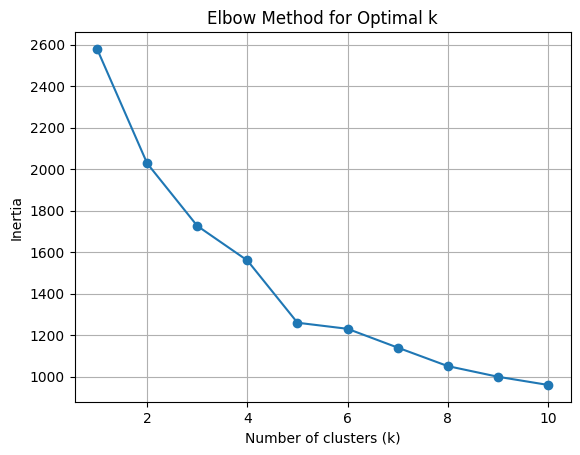

In [22]:
'''
K-Means Clustering: using only numerical data first, ignore unique_probs and session_path
- select features and drop nan values (shouldn't be any)
- normalize with the StandardScaler
- choose best_k by testing many values, visually inspecting point where increasing k yields low return
- run clustering with best_k
'''

numeric_features = ['session_duration', 'num_probs', 'num_unique_probs', 'num_practice_probs', 'num_quiz_probs', 'num_quizzes', 'num_mastered_probs', 'avg_correct',
                    'avg_practice_correct', 'avg_quiz_correct', 'avg_mastered_correct', 'avg_not_mastered_correct']

session_df['avg_mastered_correct'] = session_df['avg_mastered_correct'].fillna(0)
session_df['num_mastered_probs'] = session_df['num_mastered_probs'].fillna(0)

X = session_df[numeric_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=699)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

best_k = 5

kmeans = KMeans(n_clusters=best_k, random_state=699)
cluster_labels = kmeans.fit_predict(X_scaled)

session_df = session_df.loc[X.index]
session_df['kmeans_cluster'] = cluster_labels

K-Means Clusters and Counts:
kmeans_cluster
0    70
1    47
2    46
4    38
3    14
Name: count, dtype: int64

Summary Statistics for session_duration:
count    215.000000
mean      40.492558
std       16.841156
min       15.083333
25%       26.716667
50%       39.433333
75%       50.133333
max      133.866667
Name: session_duration, dtype: float64


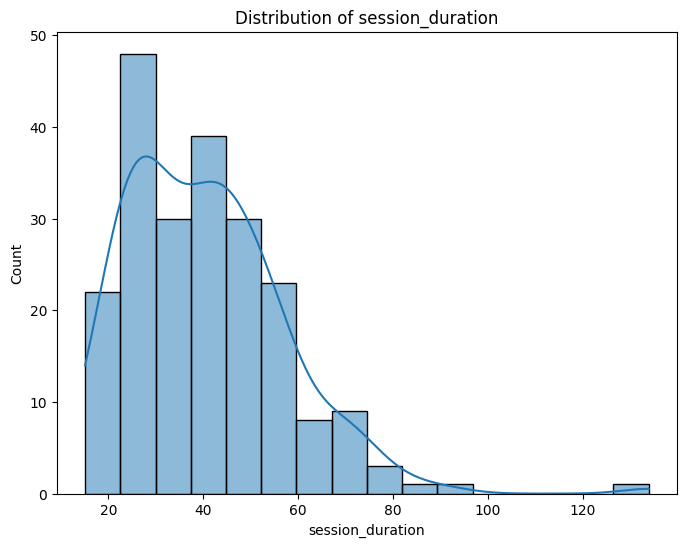


Summary Statistics for num_probs:
count    215.000000
mean      88.204651
std       91.327463
min        6.000000
25%       32.000000
50%       59.000000
75%      101.000000
max      597.000000
Name: num_probs, dtype: float64


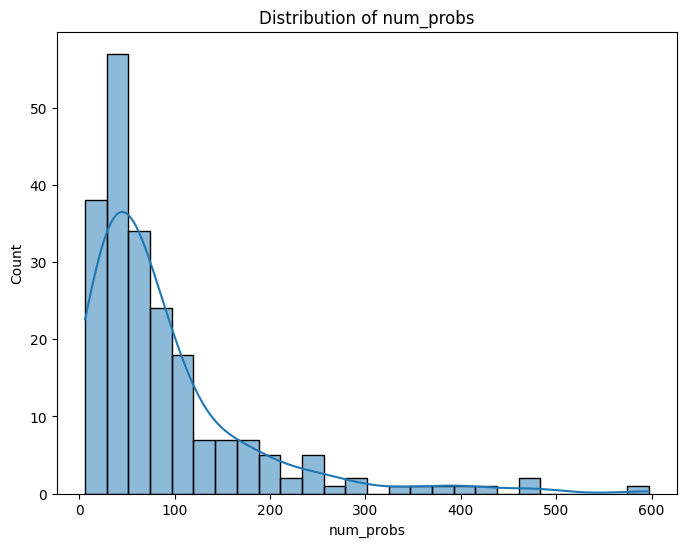


Summary Statistics for num_unique_probs:
count    215.000000
mean       4.883721
std        2.783541
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       16.000000
Name: num_unique_probs, dtype: float64


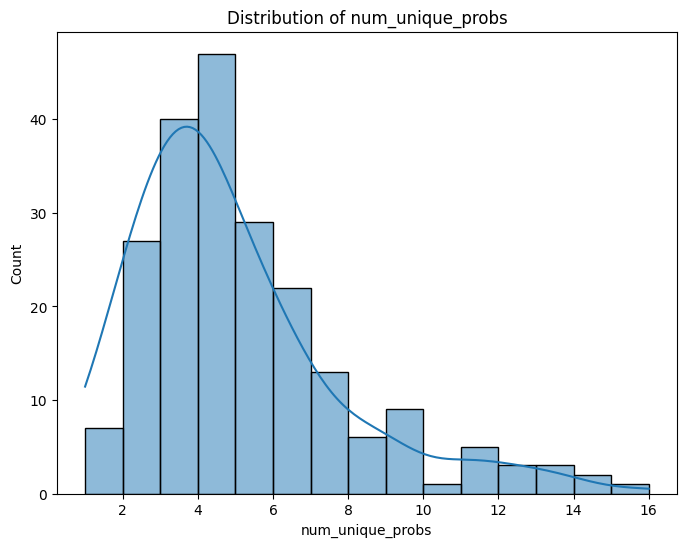


Summary Statistics for num_practice_probs:
count    215.000000
mean      58.009302
std       88.874741
min        1.000000
25%        8.000000
50%       22.000000
75%       68.000000
max      586.000000
Name: num_practice_probs, dtype: float64


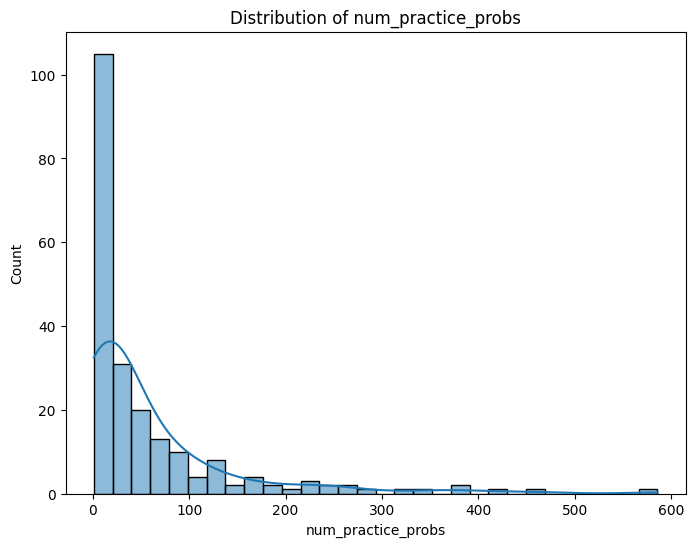


Summary Statistics for num_quiz_probs:
count    215.000000
mean      30.195349
std       25.721350
min        1.000000
25%       12.000000
50%       22.000000
75%       42.500000
max      156.000000
Name: num_quiz_probs, dtype: float64


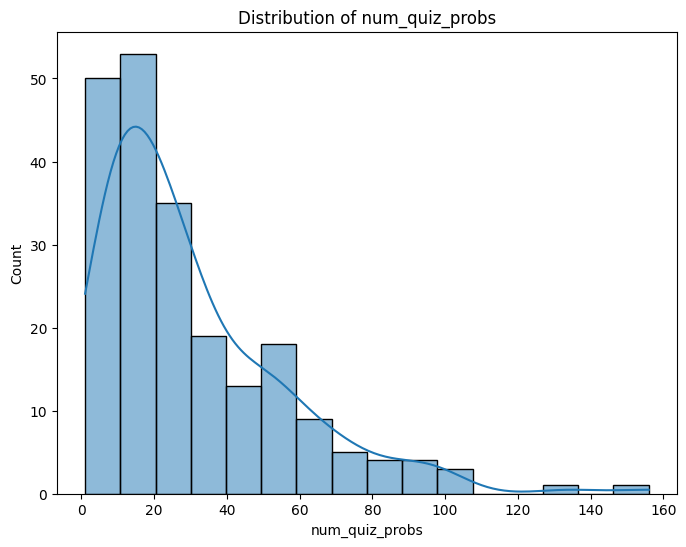


Summary Statistics for num_quizzes:
count    215.000000
mean       7.986047
std        6.338931
min        1.000000
25%        3.000000
50%        6.000000
75%       11.000000
max       30.000000
Name: num_quizzes, dtype: float64


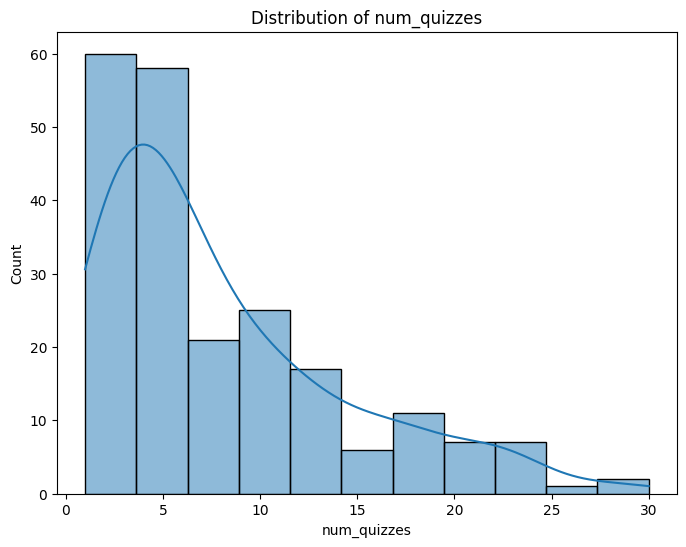


Summary Statistics for num_mastered_probs:
count    215.000000
mean      43.855814
std       82.727131
min        0.000000
25%        0.000000
50%       12.000000
75%       48.000000
max      592.000000
Name: num_mastered_probs, dtype: float64


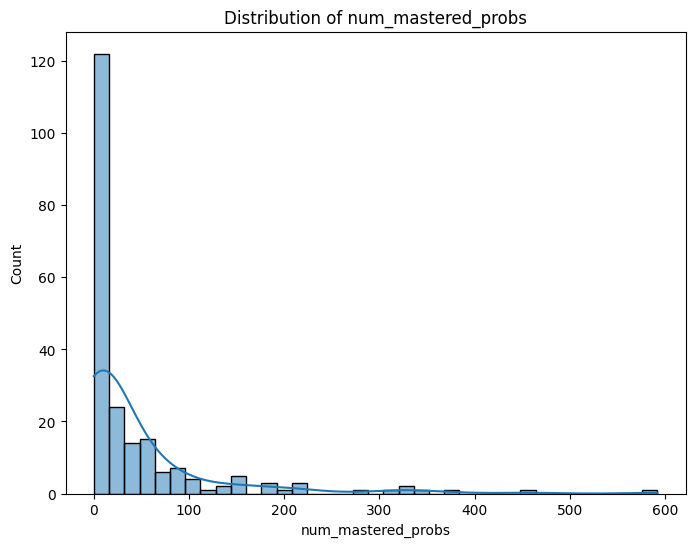


Summary Statistics for avg_correct:
count    215.000000
mean       0.803636
std        0.154722
min        0.200000
25%        0.719512
50%        0.839080
75%        0.922616
max        1.000000
Name: avg_correct, dtype: float64


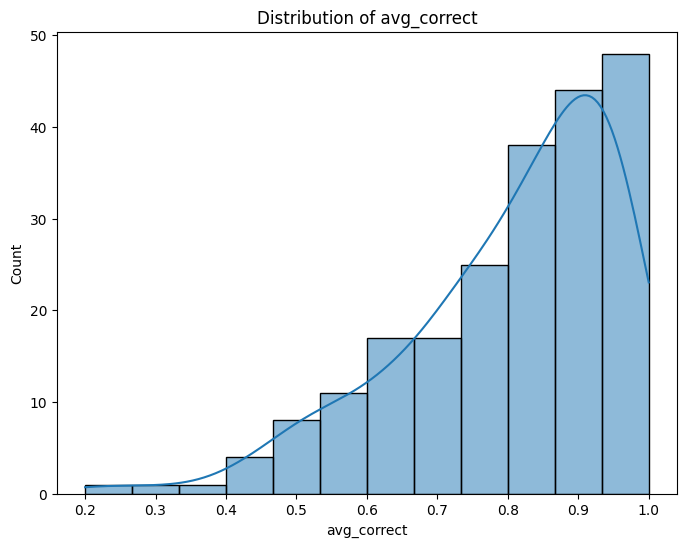


Summary Statistics for avg_practice_correct:
count    215.000000
mean       0.754146
std        0.287269
min        0.000000
25%        0.636364
50%        0.875000
75%        0.975924
max        1.000000
Name: avg_practice_correct, dtype: float64


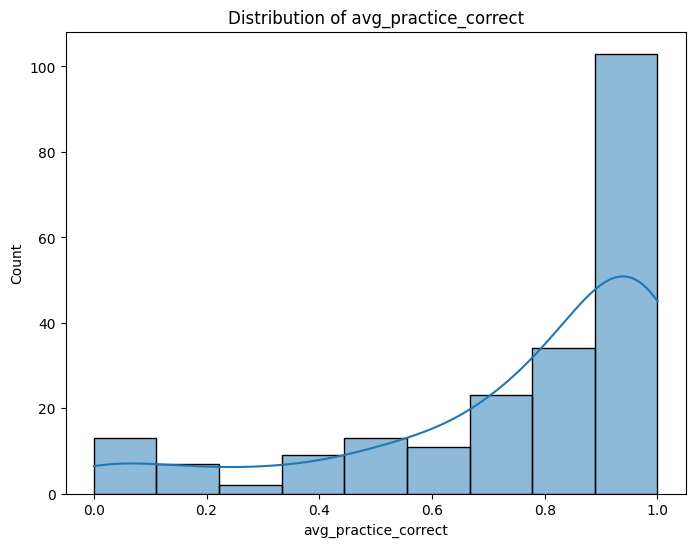


Summary Statistics for avg_quiz_correct:
count    215.000000
mean       0.765377
std        0.188992
min        0.000000
25%        0.666667
50%        0.818182
75%        0.900000
max        1.000000
Name: avg_quiz_correct, dtype: float64


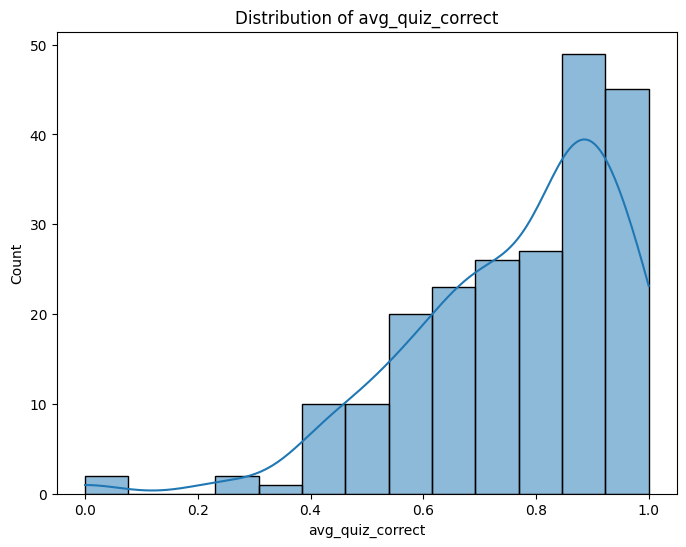


Summary Statistics for avg_mastered_correct:
count    215.000000
mean       0.606445
std        0.440899
min        0.000000
25%        0.000000
50%        0.882353
75%        0.980167
max        1.000000
Name: avg_mastered_correct, dtype: float64


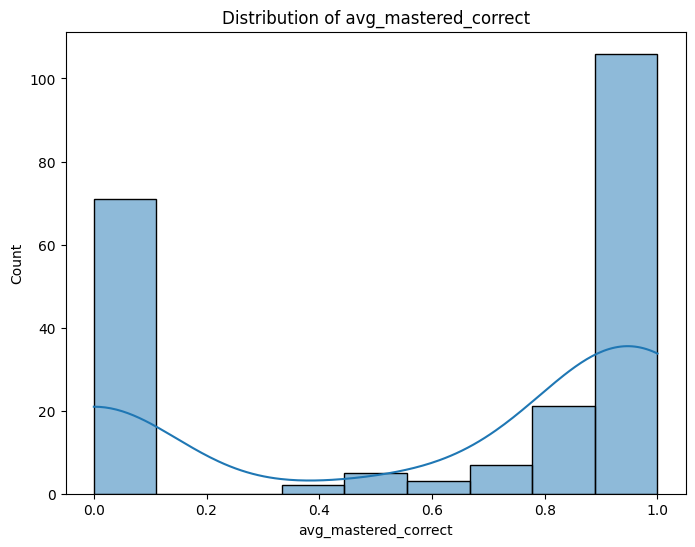


Summary Statistics for avg_not_mastered_correct:
count    215.000000
mean       0.729881
std        0.201227
min        0.000000
25%        0.601075
50%        0.769231
75%        0.884615
max        1.000000
Name: avg_not_mastered_correct, dtype: float64


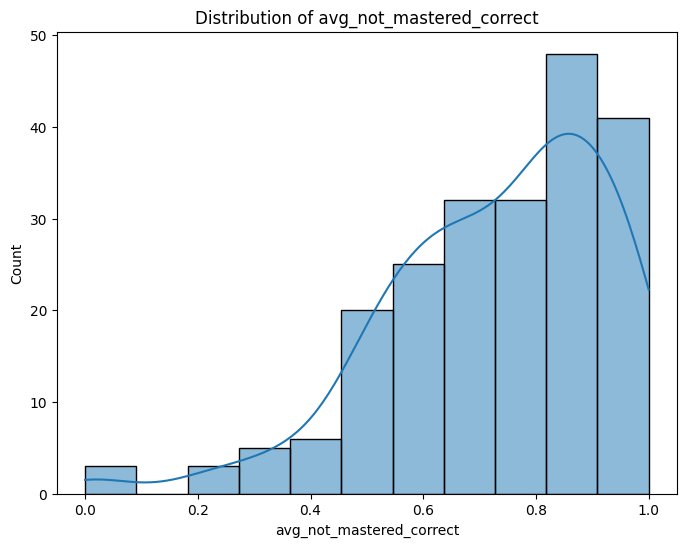

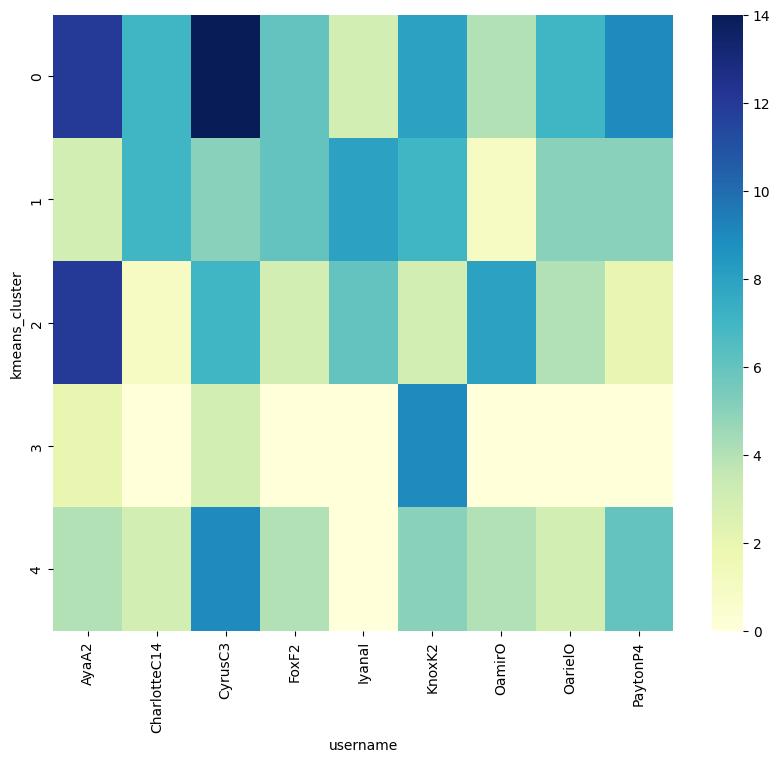

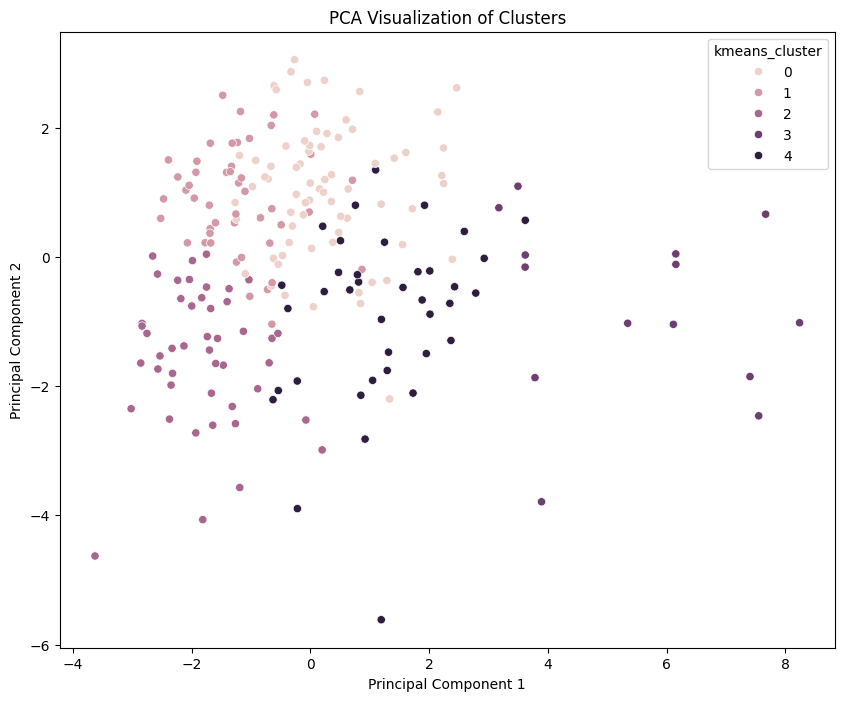

In [23]:
'''
Understanding and Visualizing Clusters:
- print summary statistics for the dataset as a whole, this will be for comparison
- print counts of each cluster
- create heatmap of clusters and usernames showing density of student experiences in each cluster
- create distribution histograms for each of the numeric_features over the entire dataset (for comparison)
- pca dimensionality reduction to visualize in 2D
- plot on a scatterplot
'''

print('K-Means Clusters and Counts:')
print(session_df['kmeans_cluster'].value_counts())

for feature in numeric_features:

  print(f'\nSummary Statistics for {feature}:')
  print(session_df[feature].describe())

  plt.figure(figsize=(8, 6))
  sns.histplot(session_df[feature], kde=True)
  plt.title(f'Distribution of {feature}')
  plt.show()

heatmap_data = pd.crosstab(session_df['kmeans_cluster'], session_df['username'])
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, fmt='d')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
session_df['pca1'] = X_pca[:, 0]
session_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=session_df, x='pca1', y='pca2', hue='kmeans_cluster')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

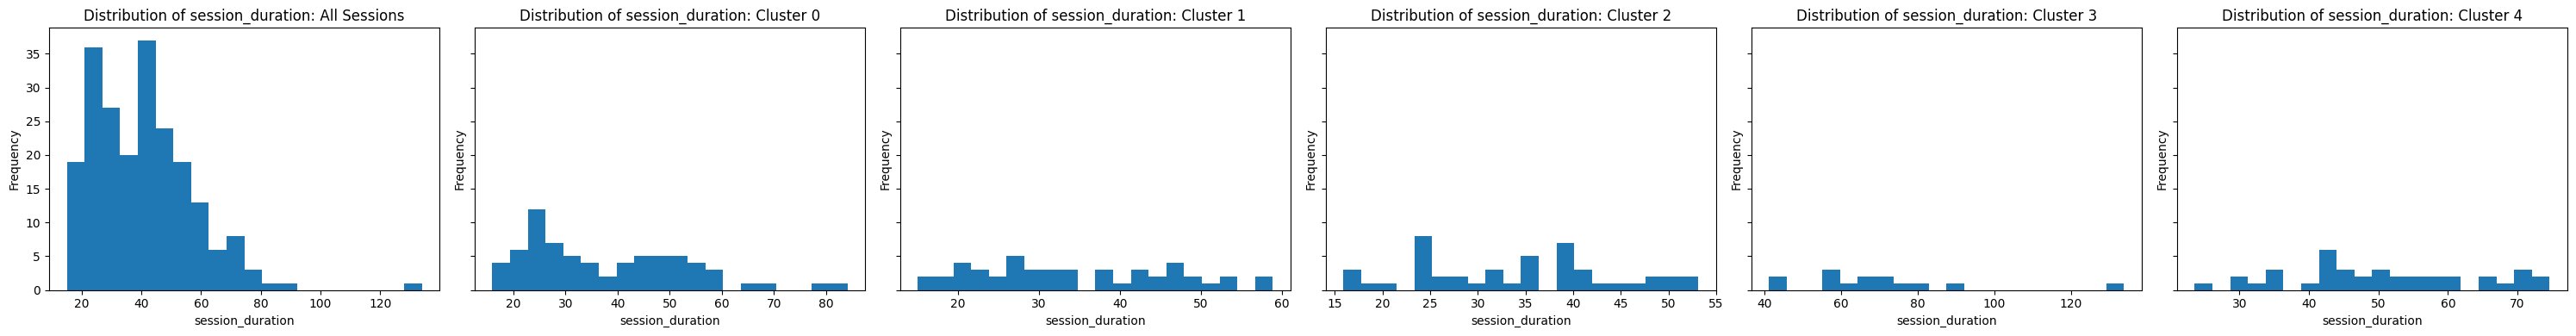

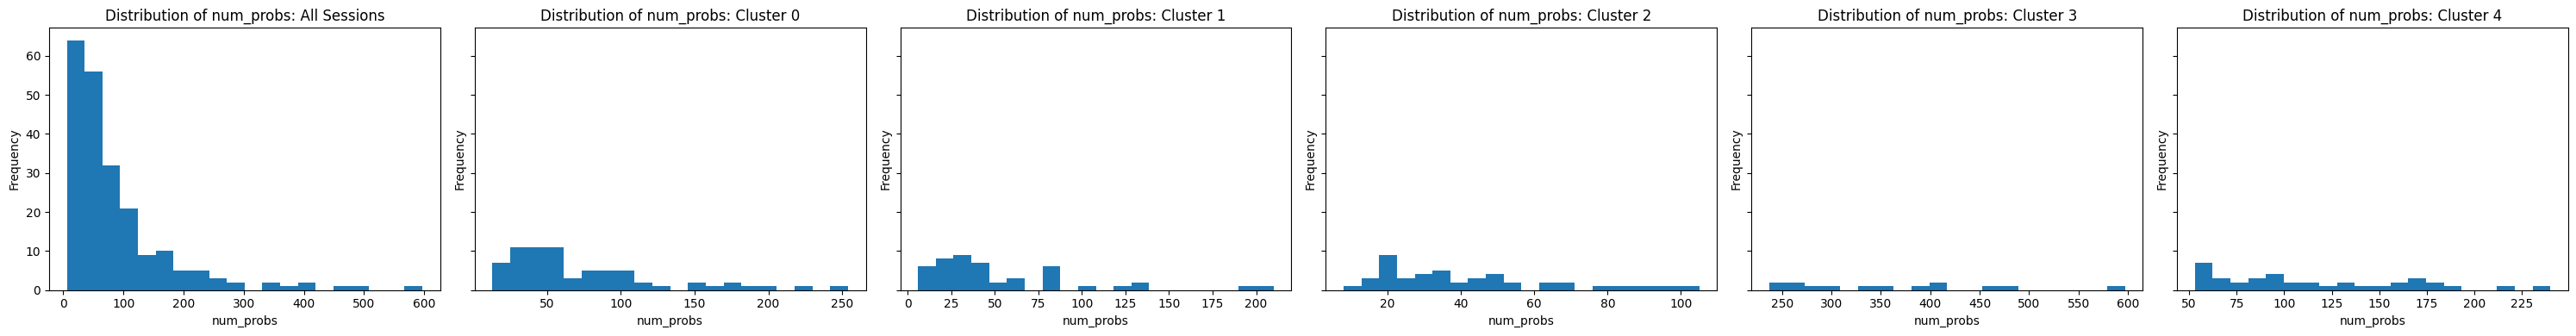

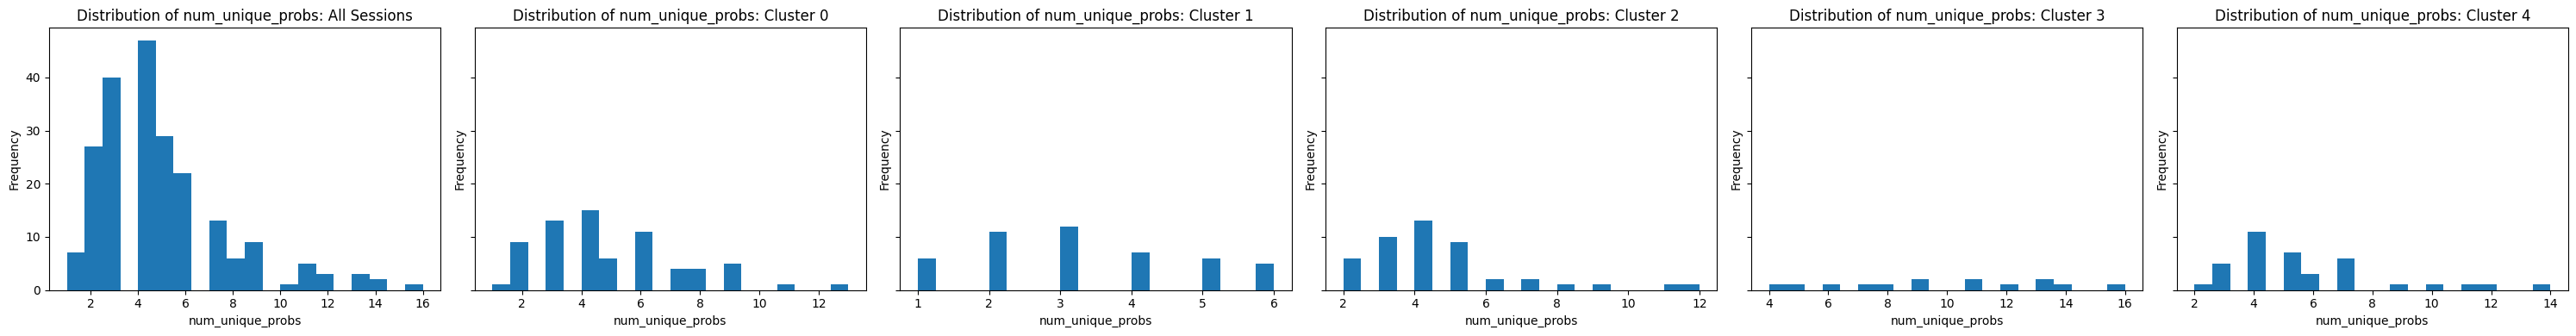

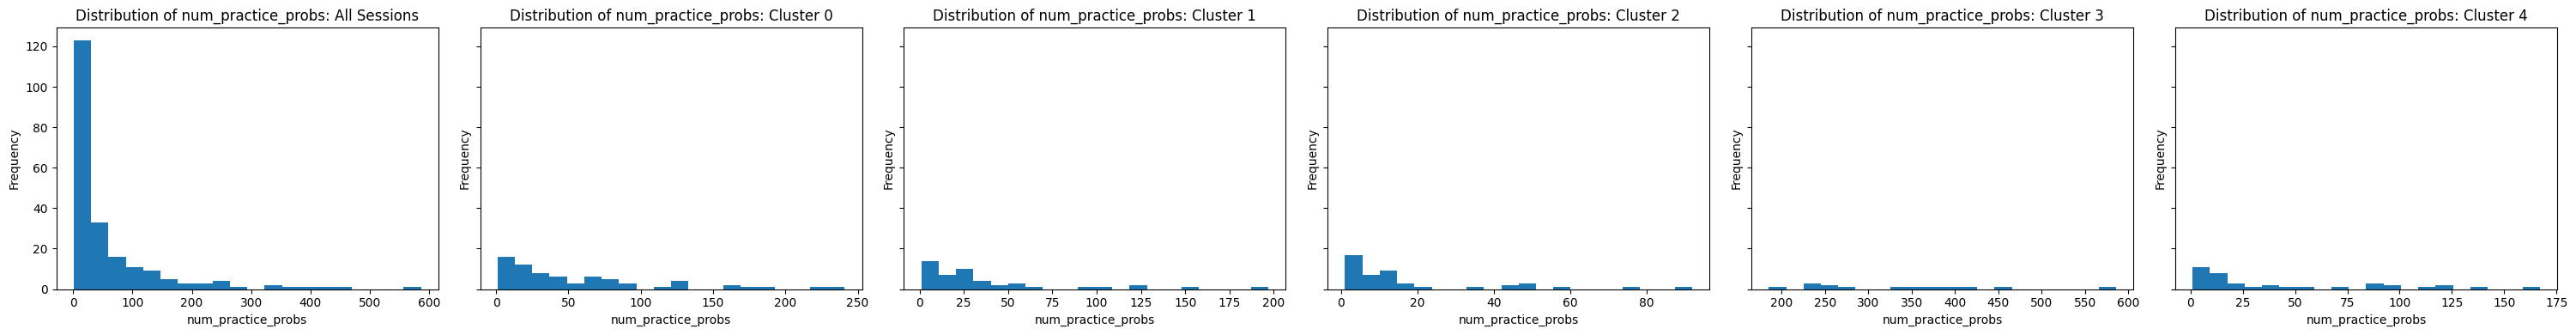

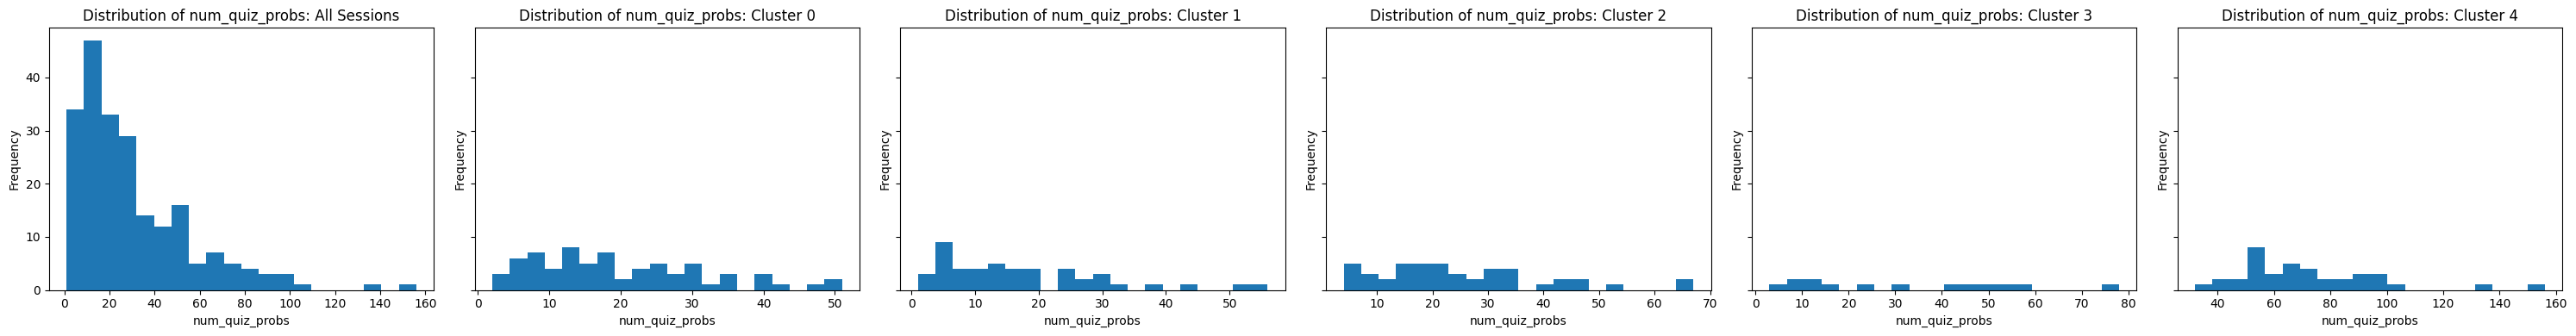

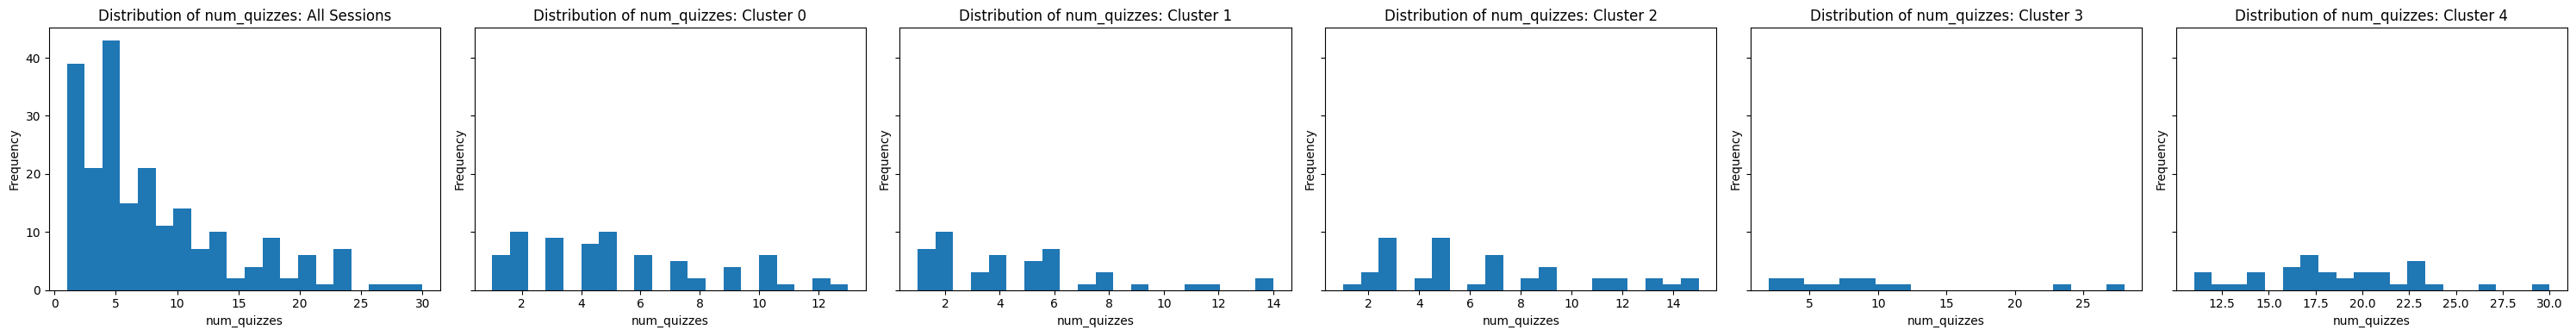

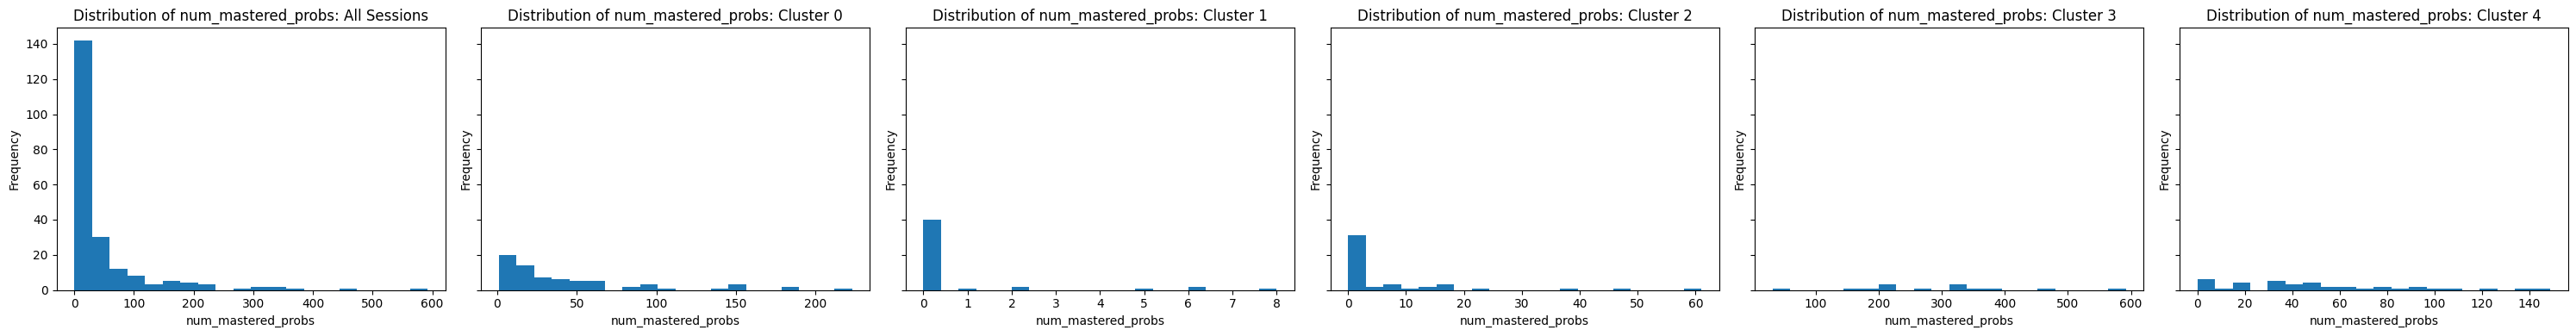

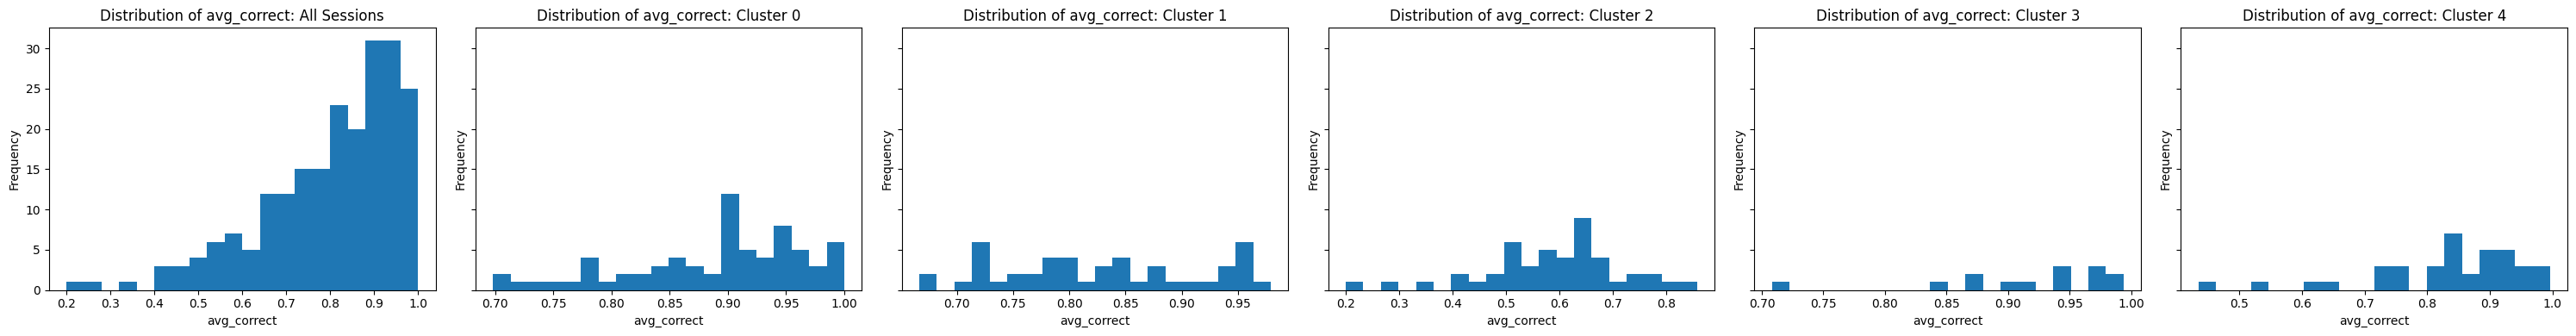

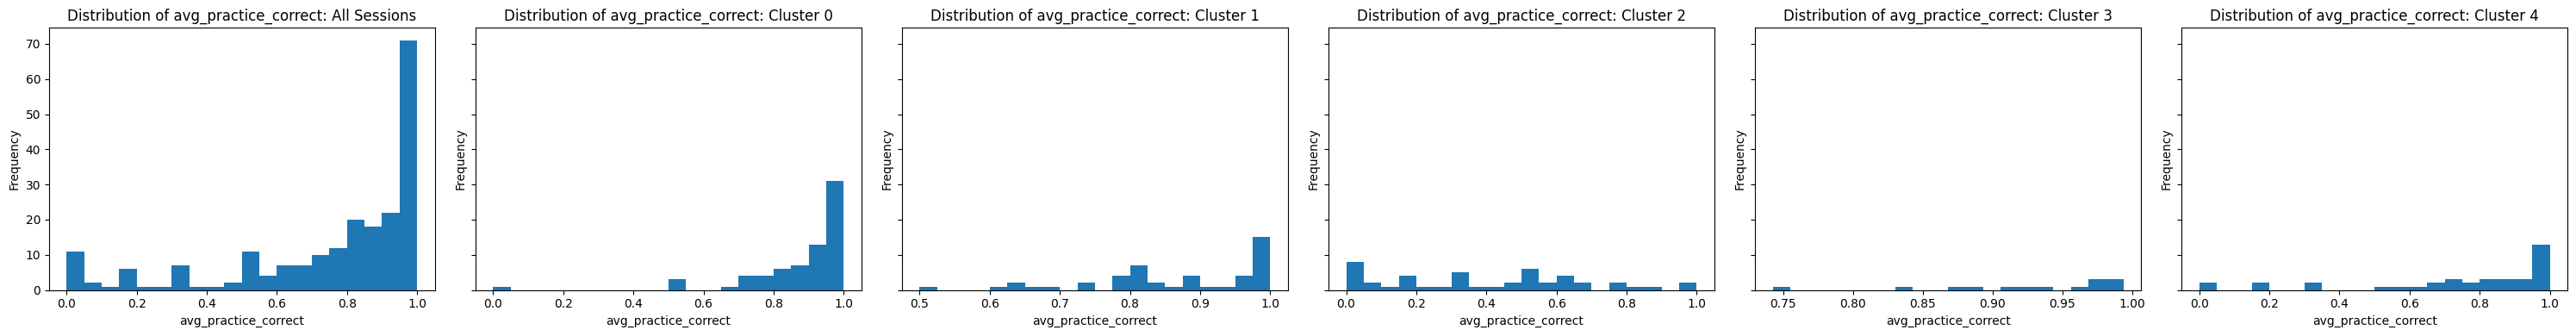

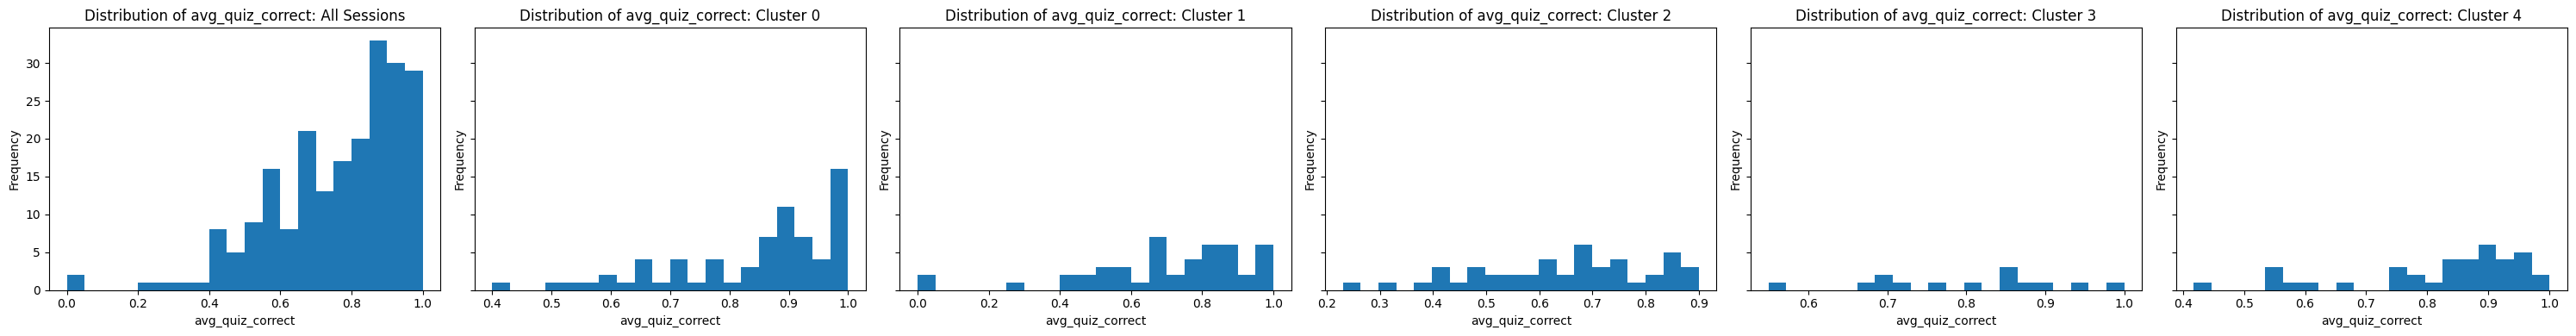

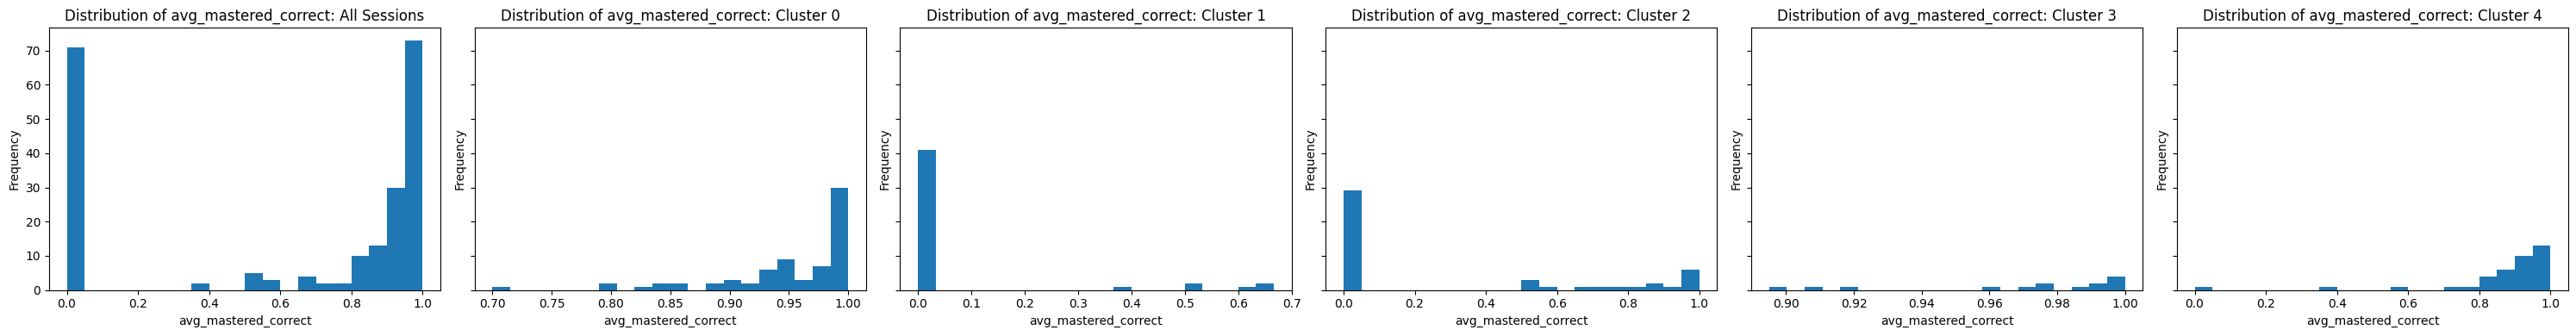

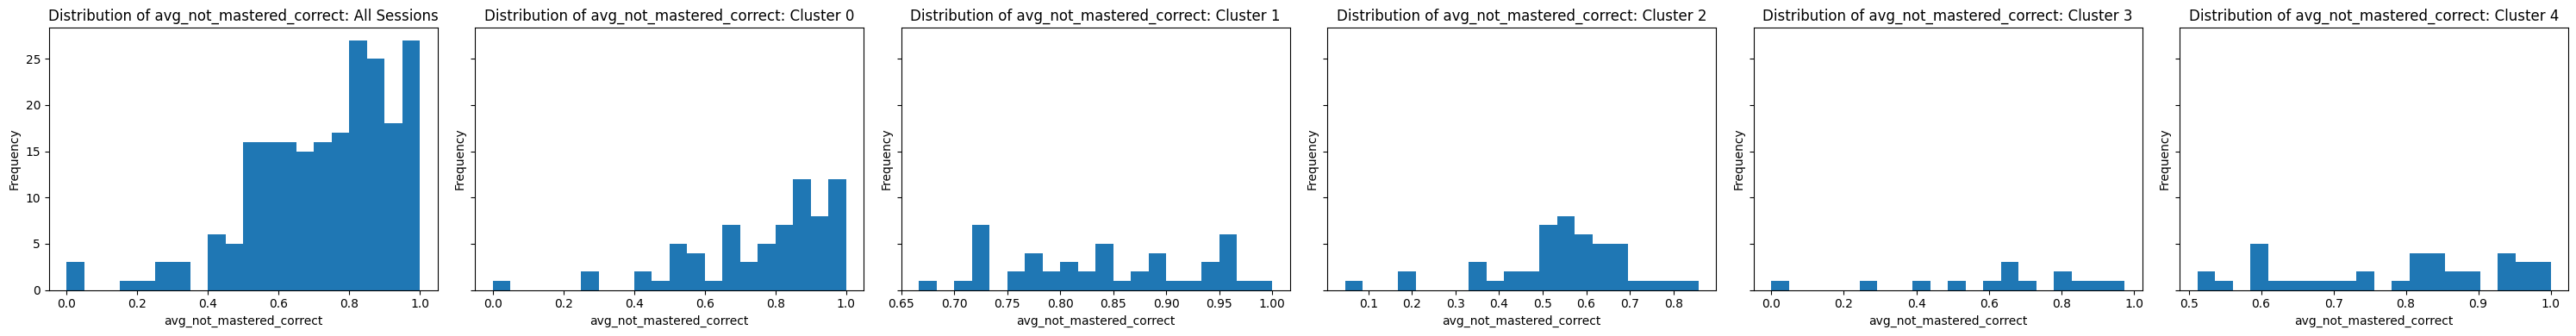

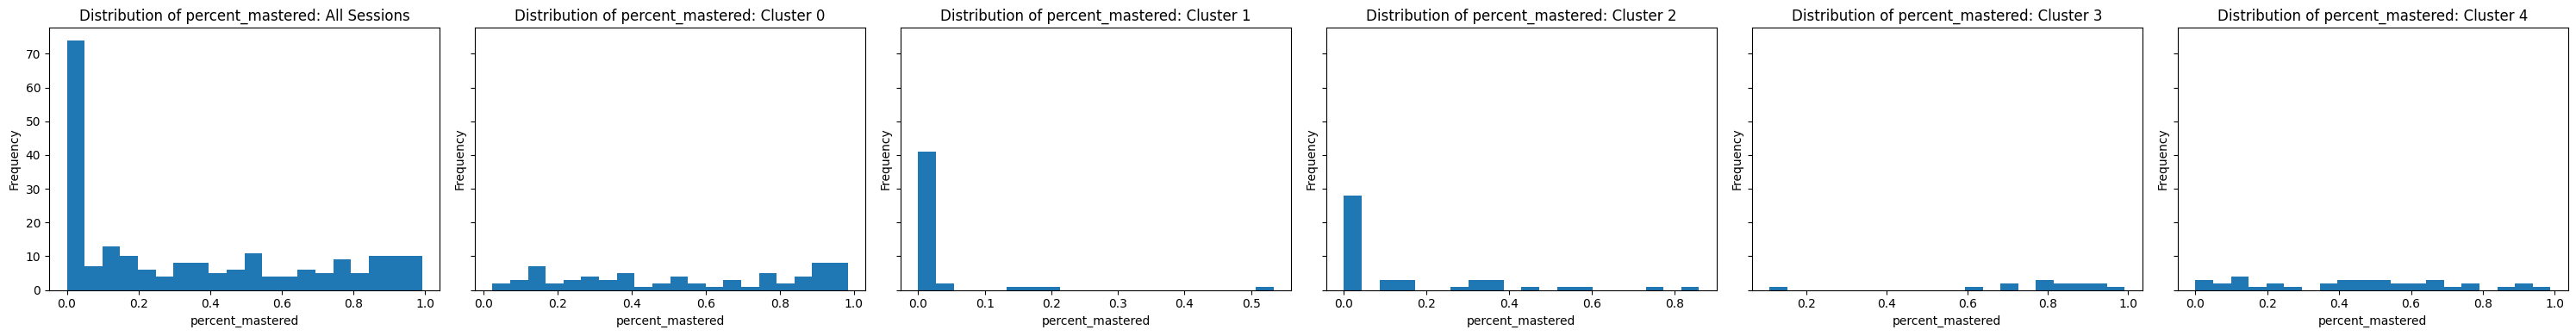

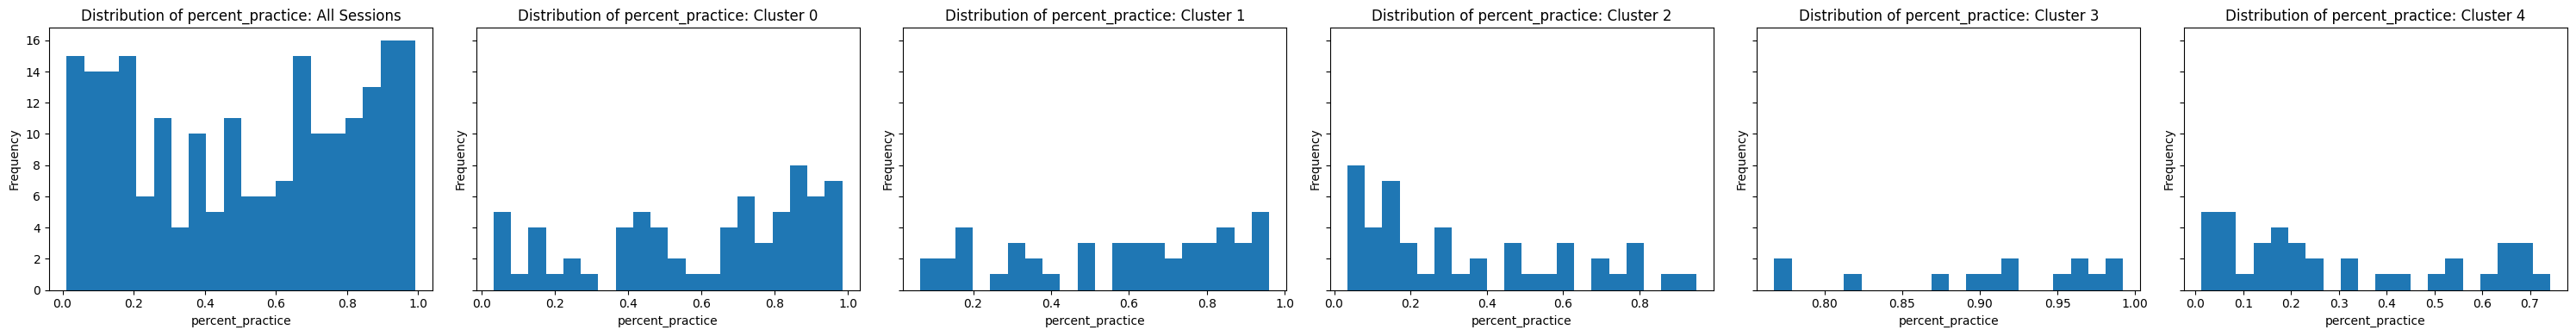

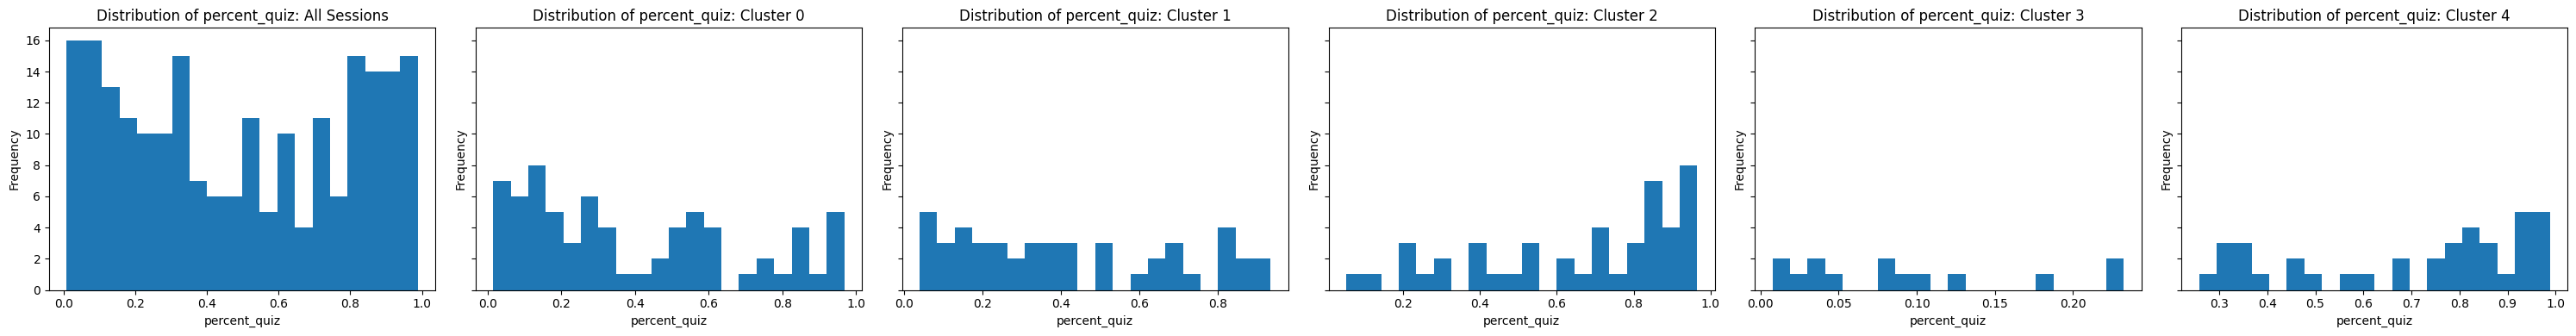

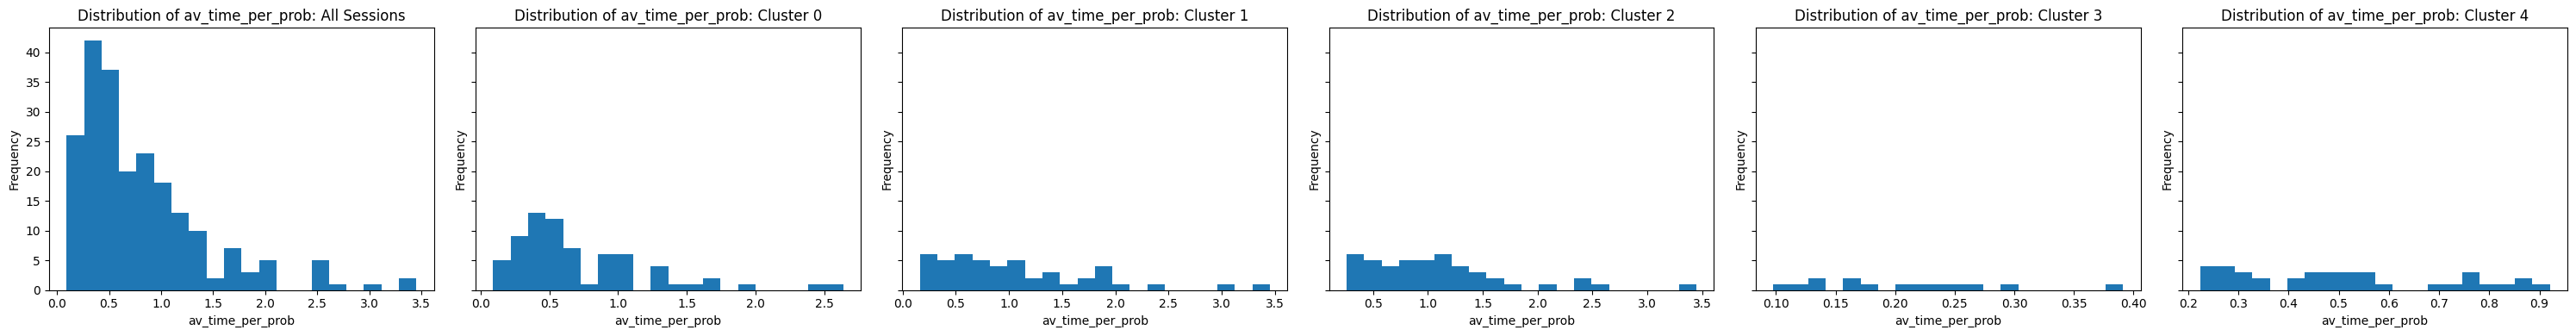

In [24]:
'''
Comparing Distributions of Numeric Features Across Clusters:
- write a function to print six plots (one for whole session_df and one for each cluster) showing the distribution of a given feature
'''

session_df['percent_practice'] = session_df['num_practice_probs'] / session_df['num_probs']
session_df['percent_quiz'] = session_df['num_quiz_probs'] / session_df['num_probs']
session_df['percent_mastered'] = session_df['num_mastered_probs'] / session_df['num_probs']
session_df['av_time_per_prob'] = session_df['session_duration'] / session_df['num_probs']

numeric_features.append('percent_mastered')
numeric_features.append('percent_practice')
numeric_features.append('percent_quiz')
numeric_features.append('av_time_per_prob')

def get_dists(feature):

  if feature not in session_df.columns:
    print(f'Error: {feature} is not a valid feature')
    return

  clusters = sorted(session_df['kmeans_cluster'].dropna().unique())
  n_clusters = len(clusters)

  fig, axes = plt.subplots(1, n_clusters+1, figsize=(5* (n_clusters+1), 4), sharey=True)

  axes[0].hist(session_df[feature].dropna(), bins=20)
  axes[0].set_title(f'Distribution of {feature}: All Sessions')
  axes[0].set_xlabel(feature)
  axes[0].set_ylabel('Frequency')

  for i, cluster in enumerate(clusters):

    cluster_df = session_df[session_df['kmeans_cluster'] == cluster][feature].dropna()
    axes[i+1].hist(cluster_df, bins=20)
    axes[i+1].set_title(f'Distribution of {feature}: Cluster {cluster}')
    axes[i+1].set_xlabel(feature)
    axes[i+1].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

for feature in numeric_features:
  get_dists(feature)

In [10]:
'''
Build Tables to Compare Clusters:
'''

def build_comp_table(feature):

  if feature not in session_df.columns:
    print(f'Error: {feature} is not a valid feature')
    return

  stat_rows = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']

  overall = session_df[feature].describe().loc[stat_rows]

  cluster_groups = session_df.groupby('kmeans_cluster')[feature].describe()
  clusters = sorted(session_df['kmeans_cluster'].dropna().unique())

  table = pd.DataFrame({'Overall': overall})

  for cluster in clusters:
    cluster_stats = cluster_groups.loc[cluster, stat_rows]
    table[f'Cluster {cluster}'] = cluster_stats

  return table.round(2)

for feature in numeric_features:
  comp_table = build_comp_table(feature)
  print(f'\nComparison Table for {feature}:')
  display(comp_table)


Comparison Table for session_duration:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,40.49,37.64,34.35,33.95,69.64,50.52
std,16.84,15.25,12.02,10.20,22.57,13.44
min,15.08,15.98,15.08,15.92,41.17,23.55
25%,26.72,25.06,24.88,25.07,58.36,42.18
50%,39.43,33.49,31.70,35.15,65.97,49.85
75%,50.13,49.06,44.60,40.50,72.96,59.85
max,133.87,84.10,58.90,53.15,133.87,74.63



Comparison Table for num_probs:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,88.20,73.66,52.81,41.78,360.14,114.79
std,91.33,52.25,45.66,24.59,106.41,49.65
min,6.00,13.00,6.00,8.00,237.00,53.00
25%,32.00,35.75,24.50,21.00,273.75,72.00
50%,59.00,55.50,37.00,35.00,349.00,100.50
75%,101.00,96.50,69.50,53.25,413.00,157.75
max,597.00,254.00,210.00,105.00,597.00,240.00



Comparison Table for num_unique_probs:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,4.88,4.90,3.23,4.46,9.86,5.58
std,2.78,2.43,1.54,2.18,3.59,2.66
min,1.00,1.00,1.00,2.00,4.00,2.00
25%,3.00,3.00,2.00,3.00,7.25,4.00
50%,4.00,4.00,3.00,4.00,10.00,5.00
75%,6.00,6.00,4.00,5.00,12.75,7.00
max,16.00,13.00,6.00,12.00,16.00,14.00



Comparison Table for num_practice_probs:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,58.01,53.83,36.02,16.93,328.93,42.82
std,88.87,54.93,42.41,21.31,110.59,47.11
min,1.00,1.00,1.00,1.00,185.00,1.00
25%,8.00,13.50,8.50,3.25,242.50,6.75
50%,22.00,35.50,22.00,9.50,304.00,17.50
75%,68.00,75.25,40.00,16.75,383.25,84.75
max,586.00,241.00,197.00,92.00,586.00,167.00



Comparison Table for num_quiz_probs:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,30.20,19.83,16.79,24.85,31.21,71.97
std,25.72,12.03,12.85,15.12,22.90,25.07
min,1.00,2.00,1.00,4.00,3.00,32.00
25%,12.00,10.00,6.50,14.25,11.50,54.00
50%,22.00,17.50,14.00,20.50,26.00,66.00
75%,42.50,27.75,24.50,33.25,49.50,85.50
max,156.00,51.00,56.00,67.00,78.00,156.00



Comparison Table for num_quizzes:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,7.99,5.23,4.64,6.59,9.36,18.39
std,6.34,3.14,3.35,3.80,7.56,4.40
min,1.00,1.00,1.00,1.00,2.00,11.00
25%,3.00,3.00,2.00,3.00,4.25,16.00
50%,6.00,5.00,4.00,5.00,8.00,18.00
75%,11.00,7.00,6.00,9.00,10.50,21.00
max,30.00,13.00,14.00,15.00,28.00,30.00



Comparison Table for num_mastered_probs:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,43.86,45.06,0.64,6.52,286.36,50.95
std,82.73,50.27,1.81,13.05,138.31,39.09
min,0.00,1.00,0.00,0.00,32.00,0.00
25%,0.00,11.25,0.00,0.00,202.75,18.00
50%,12.00,25.50,0.00,0.00,295.50,44.50
75%,48.00,56.50,0.00,7.00,337.75,75.50
max,592.00,223.00,8.00,61.00,592.00,149.00



Comparison Table for avg_correct:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.80,0.89,0.83,0.59,0.92,0.83
std,0.15,0.08,0.09,0.13,0.08,0.12
min,0.20,0.70,0.67,0.20,0.71,0.43
25%,0.72,0.85,0.76,0.51,0.88,0.77
50%,0.84,0.91,0.82,0.60,0.94,0.85
75%,0.92,0.95,0.90,0.66,0.97,0.92
max,1.00,1.00,0.98,0.86,0.99,1.00



Comparison Table for avg_practice_correct:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.75,0.88,0.86,0.40,0.93,0.75
std,0.29,0.16,0.13,0.29,0.07,0.29
min,0.00,0.00,0.50,0.00,0.74,0.00
25%,0.64,0.83,0.80,0.16,0.89,0.67
50%,0.88,0.94,0.89,0.39,0.95,0.87
75%,0.98,0.99,0.99,0.60,0.98,0.98
max,1.00,1.00,1.00,1.00,0.99,1.00



Comparison Table for avg_quiz_correct:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.77,0.85,0.71,0.64,0.80,0.82
std,0.19,0.14,0.23,0.17,0.12,0.14
min,0.00,0.40,0.00,0.23,0.55,0.42
25%,0.67,0.77,0.60,0.51,0.70,0.77
50%,0.82,0.89,0.75,0.67,0.83,0.86
75%,0.90,0.95,0.88,0.75,0.87,0.93
max,1.00,1.00,1.00,0.90,1.00,1.00



Comparison Table for avg_mastered_correct:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.61,0.95,0.07,0.30,0.97,0.87
std,0.44,0.06,0.19,0.41,0.04,0.19
min,0.00,0.70,0.00,0.00,0.90,0.00
25%,0.00,0.93,0.00,0.00,0.96,0.86
50%,0.88,0.97,0.00,0.00,0.98,0.91
75%,0.98,1.00,0.00,0.70,1.00,0.98
max,1.00,1.00,0.67,1.00,1.00,1.00



Comparison Table for avg_not_mastered_correct:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.73,0.77,0.84,0.54,0.62,0.79
std,0.20,0.21,0.09,0.15,0.26,0.15
min,0.00,0.00,0.67,0.05,0.00,0.51
25%,0.60,0.67,0.77,0.49,0.52,0.65
50%,0.77,0.83,0.83,0.56,0.64,0.82
75%,0.88,0.91,0.91,0.65,0.81,0.92
max,1.00,1.00,1.00,0.86,0.97,1.00



Comparison Table for percent_mastered:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.34,0.55,0.02,0.14,0.77,0.45
std,0.34,0.31,0.09,0.22,0.21,0.28
min,0.00,0.02,0.00,0.00,0.11,0.00
25%,0.00,0.27,0.00,0.00,0.72,0.18
50%,0.24,0.52,0.00,0.00,0.82,0.47
75%,0.65,0.87,0.00,0.25,0.88,0.65
max,0.99,0.98,0.53,0.86,0.99,0.99



Comparison Table for percent_practice:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.51,0.61,0.58,0.34,0.91,0.30
std,0.31,0.29,0.28,0.27,0.07,0.24
min,0.01,0.03,0.06,0.03,0.77,0.01
25%,0.19,0.40,0.34,0.13,0.88,0.08
50%,0.52,0.71,0.64,0.27,0.91,0.22
75%,0.80,0.87,0.83,0.54,0.96,0.53
max,0.99,0.98,0.96,0.95,0.99,0.74



Comparison Table for percent_quiz:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.49,0.39,0.42,0.66,0.09,0.70
std,0.31,0.29,0.28,0.27,0.07,0.24
min,0.01,0.02,0.04,0.05,0.01,0.26
25%,0.20,0.13,0.17,0.46,0.04,0.47
50%,0.48,0.29,0.36,0.73,0.09,0.78
75%,0.81,0.60,0.66,0.87,0.12,0.92
max,0.99,0.97,0.94,0.97,0.23,0.99



Comparison Table for av_time_per_prob:


,Overall,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
mean,0.80,0.73,1.06,1.09,0.21,0.51
std,0.62,0.52,0.75,0.67,0.08,0.21
min,0.09,0.09,0.16,0.26,0.10,0.22
25%,0.37,0.38,0.52,0.61,0.14,0.31
50%,0.61,0.58,0.84,0.95,0.20,0.49
75%,1.03,0.97,1.41,1.30,0.24,0.68
max,3.45,2.64,3.45,3.45,0.39,0.92
